In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.init
from torch.autograd import Variable

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mnist_train = dsets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=1, shuffle=True)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

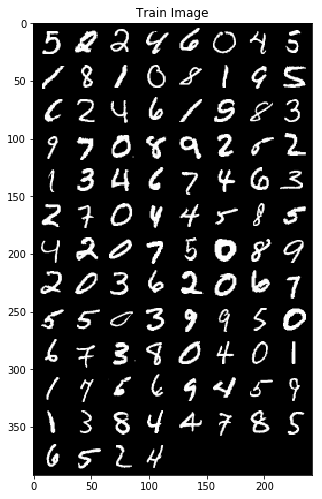

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [7]:
images.shape

torch.Size([100, 1, 28, 28])

# Define Model

In [126]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 5), # 16 * 24 * 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,5), # 32 * 20 * 20
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32 * 10 * 10
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5), # 64 * 6 * 6
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # 64 * 3 * 3
        )
        
        self.f_mu = nn.Sequential(
            nn.Linear(64 * 3 * 3, 200),
            nn.Linear(200, 50)
        )
        
        self.f_std_log = nn.Sequential(
            nn.Linear(64 * 3 * 3, 200),
            nn.Linear(200, 50)
        )
        
        self.relu = nn.ReLU()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)
                
    def encode(self, x):
        out = self.encoder(x)
        out = out.view(-1, 64 * 3 * 3)
        out = self.relu(out)
        
        mu = self.f_mu(out)
        std_log = self.f_std_log(out)
        
        return mu, std_log
    
    def f_latent(self, mu, std_log):
        if self.training:
#             std = std.pow(2)
            std = std_log.exp()
            
            random = torch.randn(std.shape)
            random = random.cuda()
            
            z = random * std + mu
            
            return z
        else:
            return mu
        
    def forward(self, x):
        mu, std_log = self.encode(x)
        z = self.f_latent(mu, std_log)
        
        return mu, std_log, z

In [127]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(50, 200),
            nn.Linear(200, 64*3*3)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,5,stride=2,padding=1), # 2 * (3 - 1) + 5 - 2 => 7
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,4,stride=2,padding=1), # 2 * (7 - 1) + 4 - 2 => 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,1,4,stride=2,padding=1), # 2 * (14 - 1) + 4 - 2 => 28
            nn.ReLU(),
            nn.Sigmoid()
        )
        
    def forward(self, z):
        out = self.fc(z)
        out = out.view(-1, 64, 3, 3)
        out = self.decoder(out)
        
        return out

In [128]:
E = Encoder().cuda()
D = Decoder().cuda()

# Model Training

In [129]:
reconstruction_loss = nn.BCELoss(reduction='sum')
# reconstruction_loss = nn.BCELoss()
def KLD_loss(mu, std_log):
    var_log = 2 * std_log
    return torch.sum(var_log.exp() + mu.pow(2) - 1 - var_log) / 2

optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr = 0.001)

In [130]:
num_epochs = 5

In [131]:
for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.cuda()
        
        # print(batch_images.cuda().shape)
        
        mu, std_log, z = E(X)
        pre = D(z)
        
        loss1 = reconstruction_loss(pre, X)
        loss2 = KLD_loss(mu, std_log)
        
        cost = loss1 + loss2
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print('loss1: %.4f, loss2: %.4f' % (loss1.item(), loss2.item()))
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

loss1: 54341.3516, loss2: 12443.3320
Epoch [1/5], lter [100/600], Loss: 66784.6875
loss1: 54312.7656, loss2: 10472.1387
Epoch [1/5], lter [200/600], Loss: 64784.9062
loss1: 54251.2656, loss2: 9686.7393
Epoch [1/5], lter [300/600], Loss: 63938.0039
loss1: 54139.2109, loss2: 9182.7773
Epoch [1/5], lter [400/600], Loss: 63321.9883
loss1: 53794.8125, loss2: 8946.1699
Epoch [1/5], lter [500/600], Loss: 62740.9844
loss1: 53221.5312, loss2: 8389.6660
Epoch [1/5], lter [600/600], Loss: 61611.1953
loss1: 53046.3477, loss2: 8042.6216
Epoch [2/5], lter [100/600], Loss: 61088.9688
loss1: 52996.1875, loss2: 7731.2256
Epoch [2/5], lter [200/600], Loss: 60727.4141
loss1: 53141.8633, loss2: 7585.3057
Epoch [2/5], lter [300/600], Loss: 60727.1680
loss1: 52829.9570, loss2: 7260.8813
Epoch [2/5], lter [400/600], Loss: 60090.8398
loss1: 52953.0039, loss2: 7256.8647
Epoch [2/5], lter [500/600], Loss: 60209.8672
loss1: 52876.0312, loss2: 6863.3223
Epoch [2/5], lter [600/600], Loss: 59739.3516
loss1: 52644.4

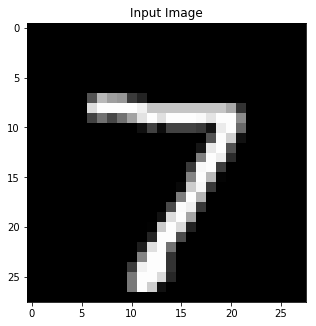

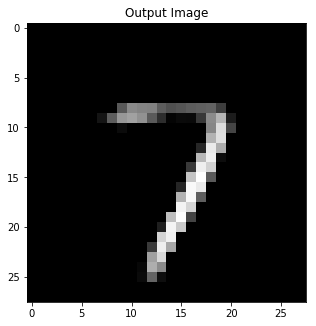

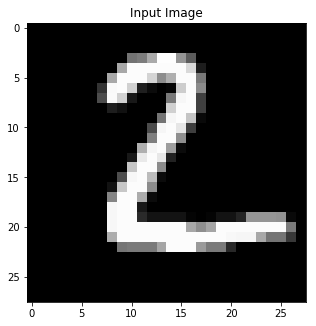

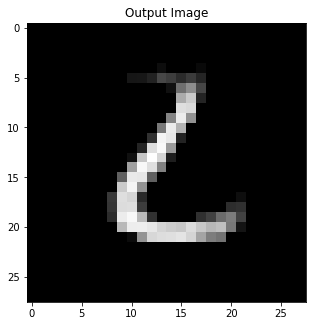

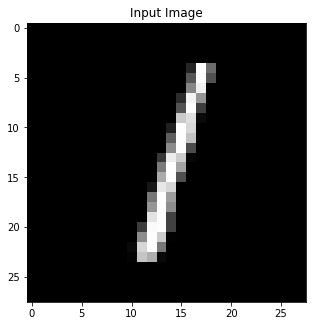

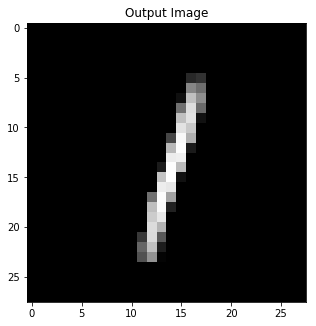

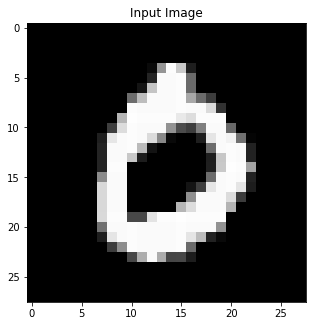

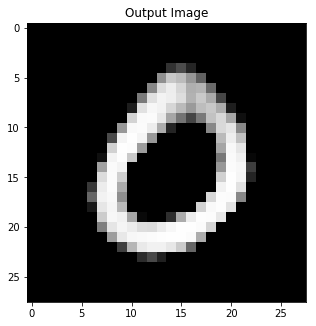

In [132]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(mnist_test):
    imshow(torchvision.utils.make_grid(images, normalize = True), "Input Image")
    images = images.view(-1, 1, 28, 28).cuda()
    mu, std_log, z = E(images)
    
    outputs = D(z)
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2: break